Notebook with tests for checking the gebco bathymetry in canadian region. 

In [29]:
import numpy as np
import xarray as xr
import os
import netCDF4 as nc4
import matplotlib.pyplot as plt

In [30]:
ncfile='bathymetry_checks/gebco_2020_tid_n63.017578125000014_s56.865234375000014_w-71.71875_e-63.28125.nc'
ncdata=nc4.Dataset(ncfile)
lon=ncdata.variables['lon']
lat=ncdata.variables['lat']
tid=ncdata.variables['tid']
print(ncdata)

KeyboardInterrupt: 

ValueError: x and y must be the same size

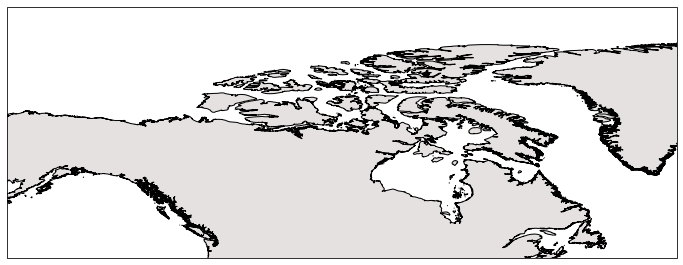

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.PlateCarree()) 
ax.set_extent([-160,-40,45,90]) 
# ax.set_extent([-180,180,45,90])  
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature)

# plt.scatter(lon,lat,c=tid,transform=ccrs.PlateCarree())
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(tid[:]).T
df.to_excel(excel_writer = "tid.xlsx")

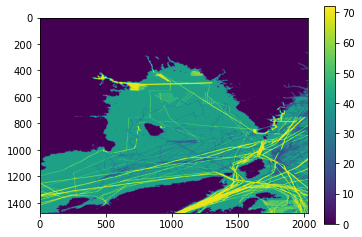

In [ ]:
plt.imshow(np.array(tid[:]))
plt.colorbar()


It seems that arctic grid is from IBCAO os I took IBCAOv4 and read the SID and TID grid


In [ ]:
sncfile='bathymetry_checks/IBCAO_v4_1_200m_SID.nc'
ncdata=nc4.Dataset(sncfile)
lon=ncdata.variables['x']
lat=ncdata.variables['y']
sid=ncdata.variables['z']
print(ncdata)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: COARDS, CF-1.5
    title: Produced by grdconvert
    history: grdconvert cut/ibcao_v4.1_200m_sid.tiff cut/ibcao_v4.1_200m_sid.nc
    description: 
    GMT_version: 5.4.5 [64-bit]
    node_offset: 1
    dimensions(sizes): x(29100), y(29100)
    variables(dimensions): float64 x(x), float64 y(y), float32 z(y, x)
    groups: 


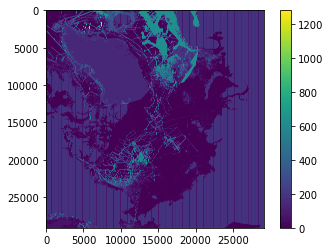

In [ ]:
plt.imshow(sid)
plt.colorbar()

In [ ]:
tncfile='bathymetry_checks/IBCAO_v4_1_200m_TID.nc'
ncdata=nc4.Dataset(tncfile)
lon=ncdata.variables['x']
lat=ncdata.variables['y']
tid=ncdata.variables['z']
print(ncdata)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: COARDS, CF-1.5
    title: Produced by grdconvert
    history: grdconvert cut/ibcao_v4.1_200m_tid.tiff cut/ibcao_v4.1_200m_tid.nc
    description: 
    GMT_version: 5.4.5 [64-bit]
    node_offset: 1
    dimensions(sizes): x(29100), y(29100)
    variables(dimensions): float64 x(x), float64 y(y), float32 z(y, x)
    groups: 


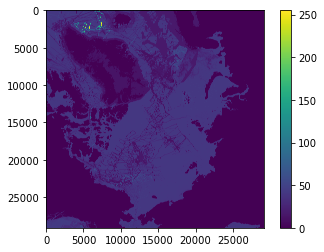

In [ ]:
plt.imshow(tid)
plt.colorbar()

Turns out canadian region is covered by Nonna-100 of canadian hydrological service. they have their vertical datum as Lower low water large tide (LLWT). To understand how this datum is wrt to MSL datum. We take tide gauge data from the CHS portal. Here is the portal https://www.qc.dfo-mpo.gc.ca/tides/en/stations Which uses an api given as https://www.qc.dfo-mpo.gc.ca/tides/en/web-services-offered-canadian-hydrographic-service#currents This api uses curl to download files which give waterlevels in .json formats.

In [ ]:
import requests

In [37]:
def readCHStide(stationid,sdate,edate):
    headers = {
        'accept': '*/*',
    }

    params = (
        ('time-series-code', 'wlp'),
        ('from', sdate ),
        ('to', edate),
    )
    chsurl='https://api-iwls.dfo-mpo.gc.ca/api/v1/stations/'+stationid+'/data'
    response = requests.get(chsurl, headers=headers, params=params)
    data=response.json()
    return(data)

#NB. Original query string below. It seems impossible to parse and
#reproduce query strings 100% accurately so the one below is given
#in case the reproduced version is not "correct". #the station id below is for a particular staiotn.
# response = requests.get('https://api-iwls.dfo-mpo.gc.ca/api/v1/stations/5cebf1e03d0f4a073c4bbd57/data?time-series-code=wlp&from=2021-01-01T00%3A00%3A00Z&to=2021-01-07T00%3A00%3A00Z', headers=headers)

In [42]:
#function test
sdate='2021-01-01T00:00:00Z'
edate='2021-01-07T00:00:00Z'
stationid='5cebf1e03d0f4a073c4bbd57'
trialdata=readCHStide(stationid,sdate,edate)


Now we have a function which gives the data for the tide gauge from CHS portal and it provides data for only 7 days. But we can script it to get a longer data

In [69]:
#getting the time and waterlevel vector
def gettimewaterlevel(data):
    tvec=[];wlvec=[]
    for ele in data:
        tvec=np.append(tvec,ele['eventDate'])
        wlvec=np.append(wlvec,ele['value'])
    return(tvec,wlvec)

In [74]:
import datetime
def getmergedata(sdate,edate,stationid):
    #getting a time vec of start and end dates based on two big start and end dates.

    tdelta=6
    ti=datetime.timedelta(days=tdelta)
    t0=datetime.datetime.strptime(sdate,"%Y-%m-%dT%H:%M:%SZ")
    tl=datetime.datetime.strptime(edate,"%Y-%m-%dT%H:%M:%SZ")
    tf_current=t0
    tl_current=t0+ti
    done=0
    t_all=[]
    while done==0:
        if (tl_current>=tl):
            done=1
            tl_current=tl
        t_all.append([tf_current,tl_current])
        tf_current=tl_current
        tl_current=tl_current+ti
    # getting time and waterlevel data and merging. 

    Tvec=[];Wlvec=[]
    for times in t_all:
        sdate=times[0].strftime("%Y-%m-%dT%H:%M:%SZ")
        edate=times[1].strftime("%Y-%m-%dT%H:%M:%SZ")
        print( sdate+' - '+edate)
        datati=readCHStide(stationid,sdate,edate)
        (tvec,wlvec)=gettimewaterlevel(datati)
        print(tvec[0],wlvec[0])
        print(tvec[-1],wlvec[-1])
        Tvec=np.append(Tvec,tvec[:-1])
        Wlvec=np.append(Wlvec,wlvec[:-1])
    return(Tvec,Wlvec)

In [77]:
stationid='5cebf1e03d0f4a073c4bbd57'
sdate='2021-01-01T00:00:00Z'  # sdate of all data
edate='2021-03-01T00:00:00Z'  # end date of all data.
(Tlvec,Wlvec)=getmergedata(sdate,edate,stationid)
print(Wlvec.mean())

2021-01-01T00:00:00Z - 2021-01-07T00:00:00Z
2021-01-01T00:00:00Z 3.557
2021-01-07T00:00:00Z 1.065
2021-01-07T00:00:00Z - 2021-01-13T00:00:00Z
2021-01-07T00:00:00Z 1.065
2021-01-13T00:00:00Z 5.234
2021-01-13T00:00:00Z - 2021-01-19T00:00:00Z
2021-01-13T00:00:00Z 5.234
2021-01-19T00:00:00Z 0.933
2021-01-19T00:00:00Z - 2021-01-25T00:00:00Z
2021-01-19T00:00:00Z 0.933
2021-01-25T00:00:00Z 3.832
2021-01-25T00:00:00Z - 2021-01-31T00:00:00Z
2021-01-25T00:00:00Z 3.832
2021-01-31T00:00:00Z 3.192
2021-01-31T00:00:00Z - 2021-02-06T00:00:00Z
2021-01-31T00:00:00Z 3.192
2021-02-06T00:00:00Z 1.448
2021-02-06T00:00:00Z - 2021-02-12T00:00:00Z
2021-02-06T00:00:00Z 1.448
2021-02-12T00:00:00Z 4.757
2021-02-12T00:00:00Z - 2021-02-18T00:00:00Z
2021-02-12T00:00:00Z 4.757
2021-02-18T00:00:00Z 1.177
2021-02-18T00:00:00Z - 2021-02-24T00:00:00Z
2021-02-18T00:00:00Z 1.177
2021-02-24T00:00:00Z 4.033
2021-02-24T00:00:00Z - 2021-03-01T00:00:00Z
2021-02-24T00:00:00Z 4.033
2021-03-01T00:00:00Z 3.785
3.050146892655367


In [73]:
Wlvec.mean()

3.0500584677419362